### <b>Import Packages</b>

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [3]:
sk.__version__

'0.23.2'

### <b>Import Data</b>

In [4]:
# df_h = pd.read_csv('/project_data/data_asset/Sample Heloc Data Dummy Values.csv')
# df_h.head()

In [5]:
import itc_utils.flight_service as itcfs

readClient = itcfs.get_flight_client()

nb_data_request = {'data_name': """Test_fields_100821_results.csv""", 'interaction_properties': {}}

flightInfo = itcfs.get_flight_info(readClient, nb_data_request=nb_data_request)

df1 = itcfs.read_pandas_and_concat(readClient, flightInfo)
df1.head()

,HALF,DOWNNUM,YARDSTOGO,SCOREDIFF,TIMELEFT,DOWNNAME,TRUEFIELD,YARDSGAINED_Mean,AVG_OVER_TOGO,PLAYIDSTR,RUN_PASS,CONCEPT_8,CONCEPT_9,pred_TD,prob_TD_NO,prob_TD_YES,pred_FIRST,prob_FIRST_NO,prob_FIRST_YES
0,0,0,5,0,480,1st,35,6.36,1.272,100000020,RUN,2,0,N,0.989180609,0.010819391,N,0.562406343,0.437593657
1,0,0,9,-7,1050,1st,45,4.756098,0.528455333,100000054,RUN,5,4,N,0.999278473,0.000721527,Y,0.439295772,0.560704228
2,0,2,4,7,600,3rd,5,8.164835,2.04120875,200000049,PASS,4,9,N,0.929719852,0.070280148,Y,0.391968242,0.608031758
3,0,0,11,7,180,1st,45,6.216667,0.565151545,200000041,PASS,4,1,N,0.999941376,5.86E-05,N,0.676802873,0.323197127
4,0,0,1,0,60,1st,45,13.416667,13.416667,200000085,PASS,8,5,N,0.800382789,0.199617211,N,0.60849475,0.39150525


In [6]:
def transform_data(data):
    ## To drop variables from a dataframe, simply list the ones you want to keep. Can pass to a new dataframe (as here) or drop from original
    df = data
    df = pd.DataFrame(df, columns=['YARDSTOGO', 'SCOREDIFF', 'TIMELEFT', 'DOWNNAME','TRUEFIELD','RUN_PASS',
       'CONCEPT_8', 'CONCEPT_9','YARDSGAINED_Mean', 'AVG_OVER_TOGO', 'prob_FIRST_YES','pred_FIRST'])

    ## Re-Name columns as needed by casting new column names using the .columns method. New columns names will be applied in order and must be same length as number of existing columns.
    df.columns = ['YARDSTOGO', 'SCOREDIFF', 'TIMELEFT', 'DOWNNAME','TRUEFIELD','RUN_PASS',
       'CONCEPT_8', 'CONCEPT_9','YARDSGAINED_Mean', 'AVG_OVER_TOGO', 'prob_FIRST','TARGET_1ST']

    ## Convert numeric fields to numeric so that they can be explored and used for analysis
    df[['YARDSTOGO','SCOREDIFF','TIMELEFT','TRUEFIELD','YARDSGAINED_Mean','AVG_OVER_TOGO',
       'CONCEPT_8','CONCEPT_9','prob_FIRST']] = df[['YARDSTOGO','SCOREDIFF','TIMELEFT','TRUEFIELD','YARDSGAINED_Mean','AVG_OVER_TOGO',
       'CONCEPT_8','CONCEPT_9','prob_FIRST']].apply(pd.to_numeric)

    df.TARGET_1ST = df.TARGET_1ST.replace({'N': 0,'Y': 1})

    ## Use the bins= parameter to specify the desired cut points for bins 
    df['TEE'] = pd.cut(df.YARDSTOGO, bins=[0, 3, 6, 10, 100],  labels=["SHORT","MED","LONG","XLONG"], include_lowest=True)

    ## For sample stratification, we need to add a variable to capture the fields on which we want to stratify
    df['STRAT_1ST'] = df['TEE'].astype(str) + df['DOWNNAME'].astype(str) + df['TARGET_1ST'].astype(str)
        
    df['PLAYID'] = df['RUN_PASS'] + df['CONCEPT_8'].astype(str)

    bin_data = pd.get_dummies(df[['RUN_PASS','PLAYID','TEE','DOWNNAME']]) ## list the fields which you want to encode
    bin_data = bin_data.drop(['RUN_PASS_PASS'], axis=1) ## where the target field is binary, first field can be dropped

    df = df.drop(['RUN_PASS','PLAYID','TEE','DOWNNAME'], axis=1) ## drop original fields
    df = pd.concat([df, bin_data], axis=1)
    
    return(df)

In [7]:
data = df1.copy()

df = transform_data(data)
df

,YARDSTOGO,SCOREDIFF,TIMELEFT,TRUEFIELD,CONCEPT_8,CONCEPT_9,YARDSGAINED_Mean,AVG_OVER_TOGO,prob_FIRST,TARGET_1ST,...,PLAYID_RUN1,PLAYID_RUN2,PLAYID_RUN3,PLAYID_RUN5,TEE_SHORT,TEE_MED,TEE_LONG,TEE_XLONG,DOWNNAME_1st,DOWNNAME_3rd
0,5,0,480,35,2,0,6.360000,1.272000,0.437594,0,...,0,1,0,0,0,1,0,0,1,0
1,9,-7,1050,45,5,4,4.756098,0.528455,0.560704,1,...,0,0,0,1,0,0,1,0,1,0
2,4,7,600,5,4,9,8.164835,2.041209,0.608032,1,...,0,0,0,0,0,1,0,0,0,1
3,11,7,180,45,4,1,6.216667,0.565152,0.323197,0,...,0,0,0,0,0,0,0,1,1,0
4,1,0,60,45,8,5,13.416667,13.416667,0.391505,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5,0,30,35,1,9,6.430769,1.286154,0.467382,0,...,1,0,0,0,0,1,0,0,0,1
9996,11,-7,1200,35,8,5,13.416667,1.219697,0.294593,0,...,0,0,0,0,0,0,0,1,0,1
9997,4,0,1050,25,3,3,6.005976,1.501494,0.612723,1,...,0,0,1,0,0,1,0,0,0,1
9998,2,7,900,5,4,9,8.164835,4.082418,0.603927,1,...,0,0,0,0,1,0,0,0,0,1


In [8]:
df = transform_data(data)

### A quick review of rescaling options and their impacts.

We can see the impacts of rescaling by quickly trying a few

In [9]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import MinMaxScaler
# #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# to_scale = pd.DataFrame(df, columns=['YARDSTOGO','SCOREDIFF','TIMELEFT','TRUEFIELD','YARDSGAINED_Mean','AVG_OVER_TOGO'])


# scaler = StandardScaler()
# scaler.fit(to_scale)
# scale_df = pd.DataFrame(scaler.transform(to_scale))
# scale_df.columns = ['YARDSTOGO','SCOREDIFF','TIMELEFT','TRUEFIELD','YARDSGAINED_Mean','AVG_OVER_TOGO']
# scale_df.head()

We can rescale potentially desired input variables at once. Saving them in memory as 'scale_df' allows us to import them if desired.

In [10]:
#scale_df.describe()

## <b>Data Selection for Model Build</b>

 ### Model Build

We will build 2 models to predict First Down, one using Logistic Regression and one with Cross-Validation.

#### Data Preparation is complete. Step 1 is Sample Splitting 

First we will save a validation sample for testing the batch deployment

In [11]:
model_df = df.sample(frac=0.8, random_state=100)
#valid_df = df[~df.index.isin(model_df.index)]
print(len(model_df)) #,len(valid_df))

8000


Working with First Down predictions, we split the data, stratifying on selected data fields, always including y </br>
If desired, we can use the substitute scaled data for raw input variables. They have already been transformed into the appropriate array. 

In [12]:
from sklearn.model_selection import train_test_split

## https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X = model_df.drop(columns = ['TARGET_1ST','STRAT_1ST'], axis = 1) ## We are using the same input variables, so the same scaled data will work. Only change is the target and stratification variables.
y = model_df['TARGET_1ST'].values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify = model_df.STRAT_1ST, random_state=121)

Now we run the Logistic Regression model

In [13]:
from sklearn.linear_model import LogisticRegression

## https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# instantiate the model
logit = LogisticRegression()

# check the default parameters
#logit.get_params()

In [14]:
import warnings

#ignore by message
warnings.filterwarnings("ignore")

# fit the model with data using the default parameters
sk_logr = logit.fit(train_X,train_y)
sk_logr.score(test_X, test_y)

0.791875

In [15]:
import sklearn.pipeline
from sklearn.metrics import roc_curve, roc_auc_score
### call pipeline.predict() on your X_test data to make a set of test predictions
sk_pred = sk_logr.predict(test_X)

### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report(test_y, sk_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       607
           1       0.81      0.86      0.84       993

    accuracy                           0.79      1600
   macro avg       0.78      0.77      0.77      1600
weighted avg       0.79      0.79      0.79      1600



In [16]:
sklearn.metrics.f1_score(test_y, sk_pred)

0.8370044052863436

In [17]:
sk_probs = sk_logr.predict_proba(test_X)
sk_probs

array([[0.20190869, 0.79809131],
       [0.06808344, 0.93191656],
       [0.25393728, 0.74606272],
       ...,
       [0.09122278, 0.90877722],
       [0.31195736, 0.68804264],
       [0.12948508, 0.87051492]])

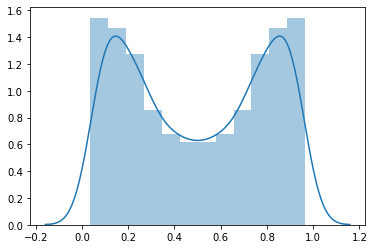

In [18]:
sns.distplot(sk_probs, kde=True, hist=True)

In [19]:
coef_logr = sk_logr.coef_
s = pd.Series(coef_logr[0])
s1 = pd.Series(10, index=X.columns)
s1_df = pd.DataFrame(s1)
s1_df[0] = s.values
#s1_df

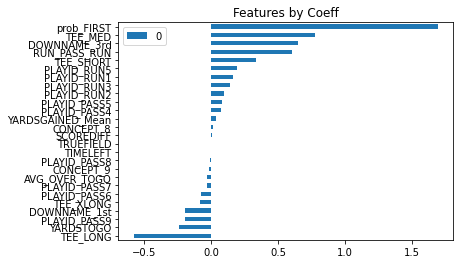

In [20]:
#LOGR_features = pd.Series(data=s1_df[0],index=df_TD.index)
s1_df.sort_values(by=0,ascending=True,inplace=True)

s1_df.plot(kind='barh')
plt.title("Features by Coeff")
plt.show()

### Build a second model using Cross Validation

In [21]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegressionCV

cv_logr = LogisticRegressionCV(cv=7, random_state=0).fit(X, y)
cv_logr.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': 7,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [22]:
cv_logr.score(X, y)

0.982625

In [23]:
cv_pred = cv_logr.predict(test_X)

report = sklearn.metrics.classification_report(test_y, cv_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       607
           1       0.98      0.99      0.98       993

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



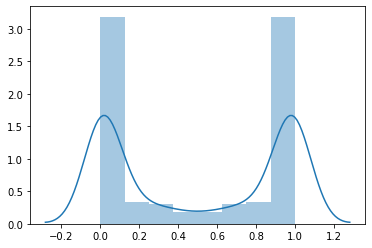

In [24]:
cv_probs = cv_logr.predict_proba(test_X)
cv_probs

sns.distplot(cv_probs, kde=True, hist=True)

### ROC Curve for Logistic Regression model

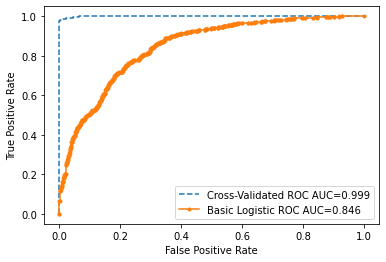

<module 'matplotlib.pyplot' from '/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [32]:
myplot = plot_roc(sk_probs, cv_probs)
myplot

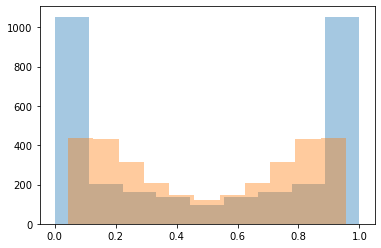

In [32]:
sns.distplot(cv_probs,hist=True,kde=False)
sns.distplot(sk_probs,hist=True,kde=False)

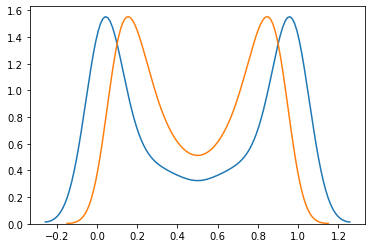

In [33]:
sns.distplot(cv_probs,hist=False,kde=True)
sns.distplot(sk_probs,hist=False,kde=True)

In [34]:
import os
import requests
import json
import time
from project_lib import Project

token = os.environ.get('USER_ACCESS_TOKEN')
project_id = os.environ.get('PROJECT_ID')
host = os.environ['RUNTIME_ENV_APSX_URL']
token

'eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6IklTQWdYV2czTE5uRVVETVg0OFB2b1BnVEEybHpCYmhxaGNaZUEyN2d5X00ifQ.eyJ1aWQiOiIxMDAwMzMxMDMwIiwidXNlcm5hbWUiOiJkYW4uc2NoZXVjaEB1cy5pYm0uY29tIiwicm9sZSI6IlVzZXIiLCJwZXJtaXNzaW9ucyI6WyJjcmVhdGVfcHJvamVjdCIsImF1dGhvcl9nb3Zlcm5hbmNlX2FydGlmYWN0cyIsInZpZXdfZ292ZXJuYW5jZV9hcnRpZmFjdHMiLCJjYW5fcHJvdmlzaW9uIiwiYWNjZXNzX2NhdGFsb2ciLCJ2aWV3X3F1YWxpdHkiLCJtYW5hZ2VfaW5mb3JtYXRpb25fYXNzZXRzIiwibWFuYWdlX21ldGFkYXRhX2ltcG9ydCIsIm1hbmFnZV9kaXNjb3ZlcnkiLCJtYW5hZ2VfcXVhbGl0eSIsImNyZWF0ZV9zcGFjZSIsImFjY2Vzc19hZHZhbmNlZF9nb3Zlcm5hbmNlX2NhcGFiaWxpdGllcyIsImFjY2Vzc19hZHZhbmNlZF9tYXBwaW5nX2NhcGFiaWxpdGllcyIsIm1hbmFnZV9jYXRhbG9nIiwiYWNjZXNzX2luZm9ybWF0aW9uX2Fzc2V0cyIsIm1hbmFnZV9zcGFjZSIsIm1vbml0b3Jfc3BhY2UiLCJtYW5hZ2VfY2F0ZWdvcmllcyIsInZpZXdfcGxhdGZvcm1faGVhbHRoIiwibWFuYWdlX3Byb2plY3QiLCJtb25pdG9yX3Byb2plY3QiLCJtYW5hZ2Vfc2VydmljZV9pbnN0YW5jZXMiLCJtYW5hZ2VfZ292ZXJuYW5jZV93b3JrZmxvdyIsIm1vbml0b3JfcGxhdGZvcm0iXSwiZ3JvdXBzIjpbMTAwMDBdLCJzdWIiOiJkYW4uc2NoZXVjaEB1cy5pYm0uY29t

In [35]:
#model_df = df.sample(frac=0.8, random_state=100)
valid_df = df1[~df1.index.isin(model_df.index)]
print(len(model_df),len(valid_df))
#df1

8000 2000


In [33]:
export_filename = 'Validation_Test_file.csv'

#export = valid_df.drop(columns = ['TARGET_1ST','STRAT_1ST'], axis = 1)
export = valid_df.copy()
project = Project(project_id=project_id, project_access_token=token)
project.save_data(export_filename, export.to_csv(index=False), overwrite=True)

{'file_name': 'Validation_Test_file.csv',
 'message': 'File saved to project storage.',
 'asset_id': '9a6aab1e-0eb6-4813-a0de-7803fbe3e313'}